Muhammad Fikri Kafilli
2107264
UAS DATA MINING
03/01/2023

Deskripsi Soal
IPM (Indeks Pembangunan Manusia) adalah ukuran kualitas sumber daya manusia. PMI memiliki tiga dimensi: (1) umur panjang dan hidup sehat (a long and healthy life), (2) pengetahuan (knowledge), dan (3) standar hidup layak (decent standard of living).  PMI dihitung menggunakan data harapan hidup, rata-rata lama sekolah, pengeluaran per kapita.

Asumsikan kategorisasi PMI adalah sebagai berikut:  <60: sangat rendah; 60 < pmi < 70: sedang; 70 < pmi < 80: rendah; >80 sangat tinggi.

Anda diminta memprediksi tingkat PMI per provinsi tanpa menggunakan data yang dapat digunakan untuk menghitung langsung (data proksi). Model ini bermanfaat untuk pengecekan silang dan dapat digunakan jika data yang diperlukan tidak tersedia. 

In [134]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import joblib
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# READ FILE

file untuk label kelas target

In [135]:
df_pmi = pd.read_table("C:\\Users\\mfkaf\\Documents\\F Upi\KULIAH3\\Data Mining\\UAS\\dataset_uas_datamining_jan_23\\pmi.csv", delimiter = ",", na_values = '-')
df_pmi.head(2)

,prov,tahun,kategori_pmi
0,ACEH,2022,TINGGI
1,SUMATERA UTARA,2022,TINGGI


file persentase penduduk yang tidak cukup pangan di setiap provinsi

In [136]:
df_nopangan = pd.read_table("C:\\Users\\mfkaf\\Documents\\F Upi\KULIAH3\\Data Mining\\UAS\\dataset_uas_datamining_jan_23\\ketidak_cukupan_pangan_prov.csv", delimiter = ",", na_values = '-')
df_nopangan.head(2)

,tahun,pct_tdk_cukup_pangan,prov
0,2021,6.90,ACEH
1,2021,6.33,SUMATERA UTARA


file tingkat kepadatan penduduk

In [137]:
df_kepadatan = pd.read_table("C:\\Users\\mfkaf\\Documents\\F Upi\KULIAH3\\Data Mining\\UAS\\dataset_uas_datamining_jan_23\\kepadatan_penduduk.csv", delimiter = ",", na_values = '-')
df_kepadatan.head(2)

,prov,tahun,kepadatan_penduduk
0,ACEH,2021,92.0
1,SUMATERA UTARA,2021,205.0


data penduduk dengan proporsi kerja nonformal dan bukan pertanian

In [138]:
df_kerja = pd.read_table("C:\\Users\\mfkaf\\Documents\\F Upi\KULIAH3\\Data Mining\\UAS\\dataset_uas_datamining_jan_23\\proporsi_kerja_informal_nonpertanian.csv", delimiter = ",", na_values = '-')
df_kerja.head(2)

,tahun,proporsi_kerja_informal_nonpertanian,prov
0,2021,46.29,ACEH
1,2021,47.53,SUMATERA UTARA


# Mengecek jumlah column, jumlah data, dan tipe data tiap column

In [139]:
df_pmi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prov          442 non-null    object
 1   tahun         442 non-null    int64 
 2   kategori_pmi  442 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.5+ KB


In [140]:
df_nopangan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tahun                 175 non-null    int64  
 1   pct_tdk_cukup_pangan  175 non-null    float64
 2   prov                  175 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


In [141]:
df_kepadatan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   prov                280 non-null    object 
 1   tahun               280 non-null    int64  
 2   kepadatan_penduduk  278 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.7+ KB


In [142]:
df_kerja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 3 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   tahun                                 245 non-null    int64  
 1   proporsi_kerja_informal_nonpertanian  245 non-null    float64
 2   prov                                  245 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 5.9+ KB


# Mengecek NULL di tiap dataframe

In [143]:
df_pmi.isna().sum()

prov            0
tahun           0
kategori_pmi    0
dtype: int64

In [144]:
df_nopangan.isna().sum()

tahun                   0
pct_tdk_cukup_pangan    0
prov                    0
dtype: int64

In [145]:
df_kepadatan.isna().sum()

prov                  0
tahun                 0
kepadatan_penduduk    2
dtype: int64

In [146]:
df_kerja.isna().sum()

tahun                                   0
proporsi_kerja_informal_nonpertanian    0
prov                                    0
dtype: int64

# Dapat dilihat dari kode di atas bahwa dataframe kepadatan penduduk memiliki 2 nilai NULL


# Mengisi Nilai NULL berdasarkan rata rata provinsinya

In [147]:
df_kepadatan['kepadatan_penduduk'].fillna(df_kepadatan.groupby("prov")['kepadatan_penduduk'].transform("mean"), inplace = True)

melihat apakah NULL sudah terisi atau belum

In [148]:
df_kepadatan.isna().sum()

prov                  0
tahun                 0
kepadatan_penduduk    0
dtype: int64

# Mengubah tipe data yang tidak cocok

In [149]:
df_kepadatan["kepadatan_penduduk"] = df_kepadatan["kepadatan_penduduk"].astype("Int64")

# Melihat rata-rata, median, dan outlier di tiap dataframe menggunakan boxplot dan describe

<AxesSubplot:xlabel='tahun'>

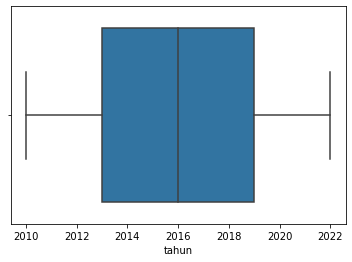

In [150]:
sns.boxplot(x="tahun",data=df_pmi) 

<AxesSubplot:xlabel='pct_tdk_cukup_pangan'>

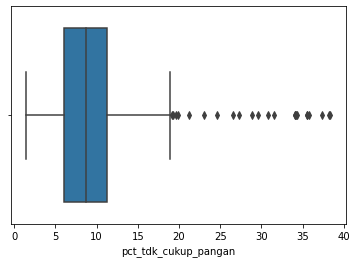

In [151]:
sns.boxplot(x="pct_tdk_cukup_pangan",data=df_nopangan) 

<AxesSubplot:xlabel='tahun'>

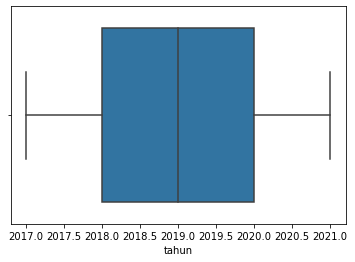

In [152]:
sns.boxplot(x="tahun",data=df_nopangan) 

<AxesSubplot:xlabel='tahun'>

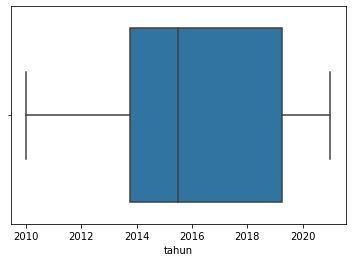

In [153]:
sns.boxplot(x="tahun",data=df_kepadatan) 

In [154]:
df_kepadatan.describe(include=('Int64'))

,tahun,kepadatan_penduduk
count,280.000000,280.000000
mean,2016.000000,698.971429
std,3.541864,2556.964684
min,2010.000000,8.000000
25%,2013.750000,48.750000
50%,2015.500000,100.500000
75%,2019.250000,243.250000
max,2021.000000,15978.000000


<AxesSubplot:xlabel='kepadatan_penduduk'>

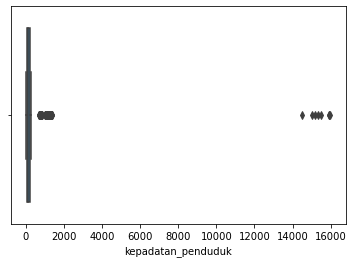

In [155]:
sns.boxplot(x="kepadatan_penduduk",data=df_kepadatan) 

menghitung banyaknya outliers

In [156]:
Q1 = df_kepadatan.quantile(0.25)
Q3 = df_kepadatan.quantile(0.75)
IQR = Q3 - Q1

mask = (df_kepadatan < (Q1 - 1.5 * IQR)) | (df_kepadatan > (Q3 + 1.5 * IQR))
mask.sum()

C:\Users\mfkaf\AppData\Local\Temp\ipykernel_9460\1332307195.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  mask = (df_kepadatan < (Q1 - 1.5 * IQR)) | (df_kepadatan > (Q3 + 1.5 * IQR))
C:\Users\mfkaf\AppData\Local\Temp\ipykernel_9460\1332307195.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  mask = (df_kepadatan < (Q1 - 1.5 * IQR)) | (df_kepadatan > (Q3 + 1.5 * IQR))


kepadatan_penduduk    56
prov                   0
tahun                  0
dtype: int64

dapat dilihat ada cukup banyak outlier pada dataframe kepadatan penduduk, sehingga tidak bisa di drop datanya 

# Merge Data Set dengan provinsi yang sama dan tahun yang sama supaya data bisa sama persis tahun dan provinsinya


In [157]:
df_final = pd.merge(df_nopangan, df_kepadatan, how="right", on=["prov"])
df_final.head(4)

,tahun_x,pct_tdk_cukup_pangan,prov,tahun_y,kepadatan_penduduk
0,2021,6.90,ACEH,2021,92
1,2020,8.58,ACEH,2021,92
2,2019,9.41,ACEH,2021,92
3,2018,8.68,ACEH,2021,92


In [158]:
df_final.isna().sum()

tahun_x                 0
pct_tdk_cukup_pangan    0
prov                    0
tahun_y                 0
kepadatan_penduduk      0
dtype: int64

In [159]:
df_final.describe()

,tahun_x,pct_tdk_cukup_pangan,tahun_y,kepadatan_penduduk
count,1400.000000,1400.000000,1400.000000,1400.000000
mean,2019.000000,10.736800,2016.000000,698.971429
std,1.414719,8.316913,3.536797,2553.306649
min,2017.000000,1.430000,2010.000000,8.000000
25%,2018.000000,6.020000,2013.750000,48.750000
50%,2019.000000,8.710000,2015.500000,100.500000
75%,2020.000000,11.260000,2019.250000,243.250000
max,2021.000000,38.350000,2021.000000,15978.000000


In [160]:
df_final = pd.merge(df_final, df_pmi, how="left", on=["prov"])
df_final.head(4)

,tahun_x,pct_tdk_cukup_pangan,prov,tahun_y,kepadatan_penduduk,tahun,kategori_pmi
0,2021,6.9,ACEH,2021,92,2022.0,TINGGI
1,2021,6.9,ACEH,2021,92,2021.0,TINGGI
2,2021,6.9,ACEH,2021,92,2020.0,TINGGI
3,2021,6.9,ACEH,2021,92,2019.0,TINGGI


In [161]:
df_final.isna().sum()

tahun_x                  0
pct_tdk_cukup_pangan     0
prov                     0
tahun_y                  0
kepadatan_penduduk       0
tahun                   40
kategori_pmi            40
dtype: int64

In [162]:
df_final.describe()

,tahun_x,pct_tdk_cukup_pangan,tahun_y,kepadatan_penduduk,tahun
count,17720.000000,17720.000000,17720.000000,17720.000000,17680.000000
mean,2019.000000,10.807630,2016.000000,714.255079,2016.000000
std,1.414253,8.414581,3.535634,2585.093489,3.741763
min,2017.000000,1.430000,2010.000000,8.000000,2010.000000
25%,2018.000000,5.970000,2013.750000,47.000000,2013.000000
50%,2019.000000,8.840000,2015.500000,98.000000,2016.000000
75%,2020.000000,11.550000,2019.250000,247.000000,2019.000000
max,2021.000000,38.350000,2021.000000,15978.000000,2022.000000


In [163]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17720 entries, 0 to 17719
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tahun_x               17720 non-null  int64  
 1   pct_tdk_cukup_pangan  17720 non-null  float64
 2   prov                  17720 non-null  object 
 3   tahun_y               17720 non-null  int64  
 4   kepadatan_penduduk    17720 non-null  Int64  
 5   tahun                 17680 non-null  float64
 6   kategori_pmi          17680 non-null  object 
dtypes: Int64(1), float64(2), int64(2), object(2)
memory usage: 1.1+ MB


In [164]:
df_final.head(30)

,tahun_x,pct_tdk_cukup_pangan,prov,tahun_y,kepadatan_penduduk,tahun,kategori_pmi
0,2021,6.90,ACEH,2021,92,2022.0,TINGGI
1,2021,6.90,ACEH,2021,92,2021.0,TINGGI
2,2021,6.90,ACEH,2021,92,2020.0,TINGGI
3,2021,6.90,ACEH,2021,92,2019.0,TINGGI
4,2021,6.90,ACEH,2021,92,2018.0,TINGGI
5,2021,6.90,ACEH,2021,92,2017.0,TINGGI
6,2021,6.90,ACEH,2021,92,2016.0,TINGGI
7,2021,6.90,ACEH,2021,92,2015.0,SEDANG
8,2021,6.90,ACEH,2021,92,2014.0,SEDANG
9,2021,6.90,ACEH,2021,92,2013.0,SEDANG


# Menghapus data kategori_pmi atau data hasil prediksi yang null  

In [165]:
# df_final.drop(df_final.loc[df_final["pct_tdk_cukup_pangan"] == NULL].index, inplace = True)
df_final = df_final.dropna(axis=0, subset=['kategori_pmi'])

In [166]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17680 entries, 0 to 17714
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tahun_x               17680 non-null  int64  
 1   pct_tdk_cukup_pangan  17680 non-null  float64
 2   prov                  17680 non-null  object 
 3   tahun_y               17680 non-null  int64  
 4   kepadatan_penduduk    17680 non-null  Int64  
 5   tahun                 17680 non-null  float64
 6   kategori_pmi          17680 non-null  object 
dtypes: Int64(1), float64(2), int64(2), object(2)
memory usage: 1.1+ MB


In [167]:
df_final.isna().sum()

tahun_x                 0
pct_tdk_cukup_pangan    0
prov                    0
tahun_y                 0
kepadatan_penduduk      0
tahun                   0
kategori_pmi            0
dtype: int64

<AxesSubplot:>

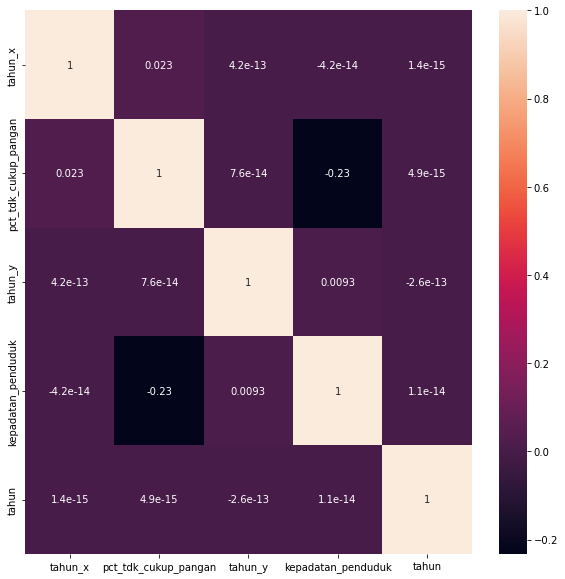

In [168]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_final.corr(), annot = True, ax=ax)

# Dapat dilihat dari heatmap diatas bahwa tahun dengan kepadatan penduduk  dan juga tahun dengan persentase pangan tidak begitu berhubungan, sedangkan yang lainnya cukup memiliki korelasi

# Mendrop kolom tahun dan prov supaya tidak menjadi feature saat modeling atau prediksi

In [169]:
df_final.drop('tahun_y', inplace=True, axis=1)
df_final.drop('tahun', inplace=True, axis=1)
df_final.drop('prov', inplace=True, axis=1)

# Mengubah tipe data kategori_PMI menjadi category

In [170]:
df_final["kategori_pmi"] = df_final["kategori_pmi"].astype("category")

# mengecek ada berapa category pada kategori_pmi

In [171]:
df_final['kategori_pmi'].unique()

['TINGGI', 'SEDANG', 'SANGAT TINGGI', 'SANGAT RENDAH']
Categories (4, object): ['SANGAT RENDAH', 'SANGAT TINGGI', 'SEDANG', 'TINGGI']

# Mulai Split Data

In [172]:
le = preprocessing.LabelEncoder()
le.fit(df_final.kategori_pmi)
Y = le.transform(df_final.kategori_pmi)

X = df_final.drop("kategori_pmi", axis=1) 

In [173]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

# Mulai membuat model dan melatih model

In [174]:
clf = RandomForestClassifier(n_estimators=200, random_state=123, max_depth=20)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print("Akurasi {}".format(acc))
print(classification_report(Y_test, Y_pred))

Akurasi 0.6561085972850679
              precision    recall  f1-score   support

           0       0.68      0.50      0.58       126
           1       0.21      0.24      0.23        62
           2       0.70      0.77      0.74      1998
           3       0.59      0.52      0.55      1350

    accuracy                           0.66      3536
   macro avg       0.55      0.51      0.52      3536
weighted avg       0.65      0.66      0.65      3536



In [175]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17680 entries, 0 to 17714
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   tahun_x               17680 non-null  int64   
 1   pct_tdk_cukup_pangan  17680 non-null  float64 
 2   kepadatan_penduduk    17680 non-null  Int64   
 3   kategori_pmi          17680 non-null  category
dtypes: Int64(1), category(1), float64(1), int64(1)
memory usage: 587.2 KB
